In [1]:
!pip install sentencepiece -q
!pip install protobuf
!pip install matplotlib

You should consider upgrading via the '/cafe/u/shrutive/myenv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/cafe/u/shrutive/myenv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/cafe/u/shrutive/myenv/bin/python -m pip install --upgrade pip' command.


In [2]:
from typing import List, Optional, Tuple, Union
import torch
import transformers
import time

device = torch.device('cpu')

print(transformers.__version__)

/cafe/u/shrutive/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.38.1


In [3]:
model_name = 'openlm-research/open_llama_3b_v2'
# model_name = 'JackFram/llama-160m'  # small Llama-like model from FlexFlow
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float32).to(device)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [46]:
'''
What I need:
positions should be the length of all the words in all the sentences
It should indicate where in their original sentence each word is from.
The mask should be so each row in the max is associated with each word from the original sentence (the corresponding index of mask).
The row should be set so that there's a 1 behind it at every token that is before it in the sentence?
I guess the unique tokens makes it so we deal with common prefixes. 
'''

import numpy as np

def construct_model_inputs(sentences):
    batch = []
    batch_tensor = []
    for t in sentences:
        batch.append(tokenizer.encode(t))
        batch_tensor.append(tokenizer.encode(t, return_tensors='pt'))
    input_0 = torch.cat(batch_tensor).to(device)
    unique_tokens = []
    for sent in batch:
        for token in sent:
            if token not in unique_tokens:
                unique_tokens.append(token)
    # print(input_0)
    input_1 = torch.tensor([unique_tokens])
    # print(input_1)
    a = input_1.shape[-1]
    b = input_0.shape[1] - 1
    mask_1 = np.zeros((a, a))
    positions = [-1] * len(unique_tokens)
    for sent in batch:
        indices = []
        for (pos, token) in enumerate(sent):
            # print(pos)
            # print(token)
            my_idx = unique_tokens.index(token)
            # print(my_idx)
            positions[my_idx] = pos
            indices.append(my_idx)
            if (mask_1[my_idx][my_idx] == 1):
                continue
            for idx in indices:
                mask_1[my_idx][idx] = 1
    mask_1 = torch.tensor(mask_1, device=device, dtype=torch.int64)
    mask_1 = mask_1.unsqueeze(0).unsqueeze(0).to(device).int()
    assert(-1 not in positions)
    position_ids_1 = torch.tensor([positions], device=device, dtype=torch.int64)
    return (input_0, input_1, mask_1, position_ids_1)

In [27]:
def time_normal(input, N_iterations):
    total_time = 0.0
    for i in range(N_iterations):
        with torch.no_grad():
            start = time.time()
            logits = model(input_ids=input).logits
            end = time.time()
        total_time += end - start
    return (total_time / N_iterations)

def time_tree(input, mask, position_ids, N_iterations):
    total_time = 0.0
    for i in range(N_iterations):
        with torch.no_grad():
            start = time.time()
            logits = model.forward(input_ids=input, attention_mask=mask, position_ids=position_ids).logits
            end = time.time()
        total_time += end - start
    return (total_time / N_iterations)

In [29]:
# EXPERIMENT 1
sentences = ['the cat sat', 'the cat had', 'the cat is', 'the cat can', 'the cat did', 'the cat was', 'the cat could', 'the cat ate', 'the cat slept', 'the cat tried', 'the cat meowed']

sequential = []
tree = []
num_sentences = []
N_iterations = 1000

for l in range(1, len(sentences), 2):
    print("Number of sentences = ", l)
    num_sentences.append(l)
    input_0, input_1, mask_1, position_ids_1 = construct_model_inputs(sentences[0:l])
    sequential.append(time_normal(input_0, N_iterations))
    print("Computed normal time")
    print(input_1)
    print(mask_1)
    print(position_ids_1)
    tree.append(time_tree(input_1, mask_1, position_ids_1, N_iterations))
    print("Computed parallel time")
    print("------------------------------")

Number of sentences =  1
Computed normal time
tensor([[   1,  268, 3627, 2791]])
tensor([[[[1, 0, 0, 0],
          [1, 1, 0, 0],
          [1, 1, 1, 0],
          [1, 1, 1, 1]]]], dtype=torch.int32)
tensor([[0, 1, 2, 3]])
Computed parallel time
------------------------------
Number of sentences =  3
Computed normal time
tensor([[   1,  268, 3627, 2791,  663,  325]])
tensor([[[[1, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 0, 0],
          [1, 1, 1, 0, 1, 0],
          [1, 1, 1, 0, 0, 1]]]], dtype=torch.int32)
tensor([[0, 1, 2, 3, 3, 3]])
Computed parallel time
------------------------------
Number of sentences =  5
Computed normal time
tensor([[   1,  268, 3627, 2791,  663,  325,  454,  909]])
tensor([[[[1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 0, 1, 0, 0, 0],
          [1, 1, 1, 0, 0, 1, 0, 0],
          [1, 1, 1, 0, 0,

In [47]:
# EXPERIMENT 2
sentences = [['the dog barked and it scared that girl', 'the cat meowed super loudly last night'],
             ['the dog barked and it scared that girl', 'the dog meowed super loudly last night'],
             ['the dog barked and it scared that girl', 'the dog barked super loudly last night'],
             ['the dog barked and it scared that girl', 'the dog barked and loudly last night'],
             ['the dog barked and it scared that girl', 'the dog barked and it last night'],
             ['the dog barked and it scared that girl', 'the dog barked and it scared night'],
             ['the dog barked and it scared that girl', 'the dog barked and it scared that night'],
             ['the dog barked and it scared that girl', 'the dog barked and it scared that girl']]

sequential = []
tree = []
num_sentences = []
N_iterations = 1000

for l in range(len(sentences)):
    print("Number of shared words = ", l + 1)
    num_sentences.append(l)
    input_0, input_1, mask_1, position_ids_1 = construct_model_inputs(sentences[l])
    sequential.append(time_normal(input_0, N_iterations))
    print("Computed normal time")
    print(input_1)
    print(mask_1)
    print(position_ids_1)
    tree.append(time_tree(input_1, mask_1, position_ids_1, N_iterations))
    print("Computed parallel time")
    print("------------------------------")
    

Number of shared words =  1
Computed normal time
tensor([[    1,   268,  3095, 21514,   286,   295,   358, 14796,   347,  2345,
          3627,   508, 12494,  2492, 10426,   338,  1107,  1824]])
tensor([[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
          [1,

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 10 but got size 9 for tensor number 1 in the list.

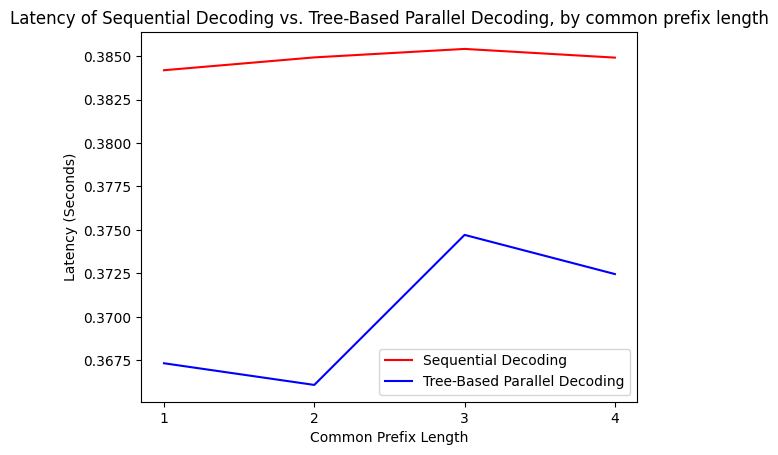

In [58]:
import matplotlib.pyplot as plt

# FOR EXPERIMENT 2
num_sentences = [1, 2, 3, 4]
plt.plot(num_sentences, sequential, 'r', label='Sequential Decoding')
plt.plot(num_sentences, tree, 'b', label='Tree-Based Parallel Decoding')
plt.title('Latency of Sequential Decoding vs. Tree-Based Parallel Decoding, by common prefix length')
plt.legend()
plt.xticks(range(1,5))
plt.xlabel('Common Prefix Length')
plt.ylabel('Latency (Seconds)')
plt.show()